<a href="https://colab.research.google.com/github/koalanoir/Prediction_elections_presidentiels/blob/main/Etude_tx_d_abstention_election_presidentielle_france.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim

In [46]:
# création d'un set pour l'évolution du taux d'abstention en france depuis 1995
set_abs_premier_tour = {'Années': [1995, 2002,2007,2012,2017],
        'Abstention': [21.23, 28.39, 16.23,20.51, 22.22]}
df = pd.DataFrame(set_abs_premier_tour)
df_2022=pd.read_excel("/content/drive/MyDrive/dataset/2022_reg.xlsx")
df_2022_com=pd.read_excel("/content/drive/MyDrive/dataset/departement_2022.xlsx")
df_2022_dep=pd.read_excel("/content/drive/MyDrive/dataset/resultats-par-niveau-dpt-t1-france-entiere.xlsx")

In [16]:

df_2022.head()

,Code de la région,Libellé de la région,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,44,Grand Est,Complet,3862920,1008344,26.10,2854576,73.90,42255,1.09,...,Philippe,22241,0.58,0.80,M,DUPONT-AIGNAN,Nicolas,74916,1.94,2.68
1,75,Nouvelle-Aquitaine,Complet,4463041,962499,21.57,3500542,78.43,53440,1.20,...,Philippe,32597,0.73,0.95,M,DUPONT-AIGNAN,Nicolas,67645,1.52,1.98
2,84,Auvergne-Rhône-Alpes,Complet,5557535,1228490,22.10,4329045,77.90,70067,1.26,...,Philippe,30586,0.55,0.72,M,DUPONT-AIGNAN,Nicolas,98446,1.77,2.33
3,27,Bourgogne-Franche-Comté,Complet,1992409,456682,22.92,1535727,77.08,26392,1.32,...,Philippe,12738,0.64,0.85,M,DUPONT-AIGNAN,Nicolas,38691,1.94,2.58
4,53,Bretagne,Complet,2562061,543414,21.21,2018647,78.79,31884,1.24,...,Philippe,19913,0.78,1.01,M,DUPONT-AIGNAN,Nicolas,35116,1.37,1.78


In [8]:
df_2022_dep.head()

,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,...,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102
0,01,Ain,1,L'Abergement-Clémenciat,Complet,645,108,16.74,537,83.26,...,3,0.47,0.58,12,M,DUPONT-AIGNAN,Nicolas,21,3.26,4.04
1,01,Ain,2,L'Abergement-de-Varey,Complet,213,38,17.84,175,82.16,...,3,1.41,1.75,12,M,DUPONT-AIGNAN,Nicolas,0,0.00,0.00
2,01,Ain,4,Ambérieu-en-Bugey,Complet,8765,2078,23.71,6687,76.29,...,43,0.49,0.66,12,M,DUPONT-AIGNAN,Nicolas,181,2.07,2.76
3,01,Ain,5,Ambérieux-en-Dombes,Complet,1282,234,18.25,1048,81.75,...,2,0.16,0.19,12,M,DUPONT-AIGNAN,Nicolas,27,2.11,2.63
4,01,Ain,6,Ambléon,Complet,103,23,22.33,80,77.67,...,0,0.00,0.00,12,M,DUPONT-AIGNAN,Nicolas,1,0.97,1.30


In [36]:
donnees_44 = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['44', '49', '85','53','72'])]
donnees_outre_mer = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['ZA','ZB','ZC','ZD','ZM','ZN','ZP','ZS','ZW','ZX','ZY','ZZ'])]
donnees_ile_france = df_2022_dep.loc[df_2022_dep['Code du département'].isin(['91', '92', '93','75','78','77','94','95'])]

In [47]:
donnees_ile_de_france_commune=df_2022_com.loc[df_2022_com['Code du département'].isin(['91', '92', '93','75','78','77','94','95'])]

In [51]:
population=pd.read_excel("/content/drive/MyDrive/dataset/dep93.xlsx")
population.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Populations légales des arrondissements en vigueur au 1er janvier 2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Mise à jour : décembre 2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,en habitant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Champ : Département de la Seine-Saint-Denis, l...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Date de référence statistique : 1er janvier 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Source :,"Insee, Recensement de la population 2020",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:

def extraireDfFromExcel(chemin_fichier):
# Lire les noms de toutes les feuilles de calcul
  xl = pd.ExcelFile(chemin_fichier)
  feuilles = xl.sheet_names

# Créer un dictionnaire pour stocker les DataFrames de chaque feuille
  dataframes = {}

# Lire chaque feuille de calcul et stocker les données dans le dictionnaire
  for feuille in feuilles:
      df = pd.read_excel(chemin_fichier, sheet_name=feuille)
      dataframes[feuille] = df
  return dataframes

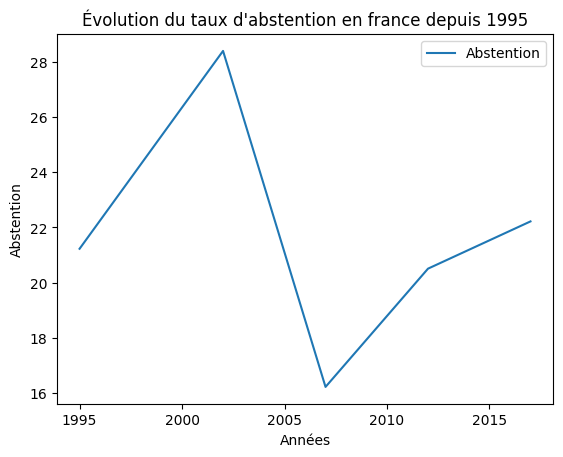

In [11]:


df.plot(x='Années', y='Abstention', kind='line')
plt.xlabel('Années')
plt.ylabel('Abstention')
plt.title("Évolution du taux d'abstention en france depuis 1995")
plt.show()

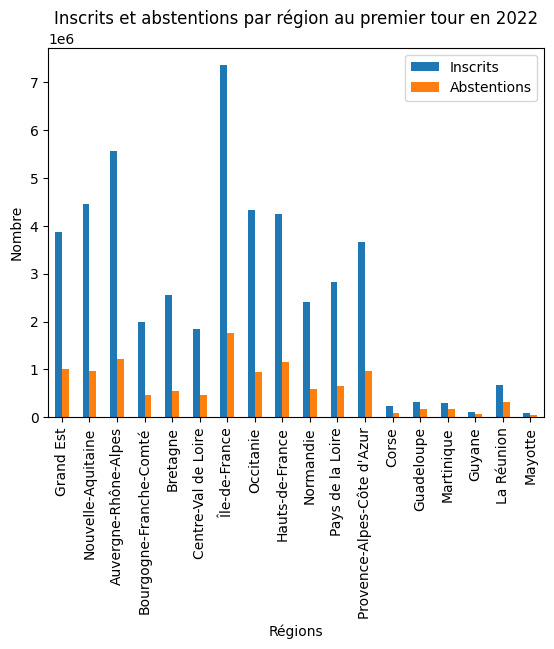

In [18]:
df_2022.plot(x='Libellé de la région', y=['Inscrits', 'Abstentions'], kind='bar')
plt.xlabel('Régions')
plt.ylabel('Nombre')
plt.title('Inscrits et abstentions par région au premier tour en 2022')
plt.legend(["Inscrits", "Abstentions"])
plt.show()

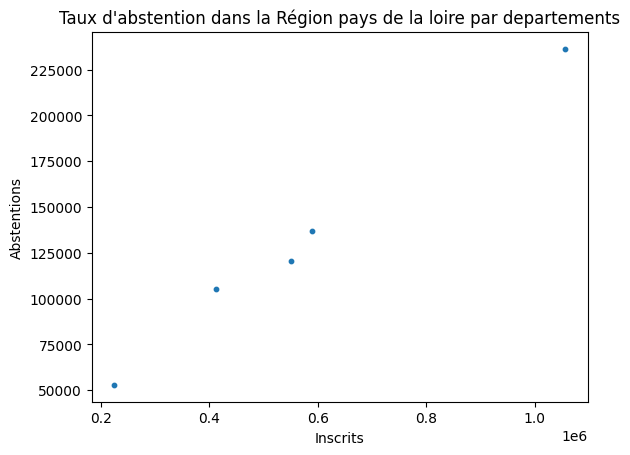

In [38]:

plt.scatter(donnees_44['Inscrits'], donnees_44['Abstentions'],s=10)
plt.xlabel('Inscrits')
plt.ylabel('Abstentions')
plt.title("Taux d'abstention dans la Région pays de la loire par departements")
plt.show()

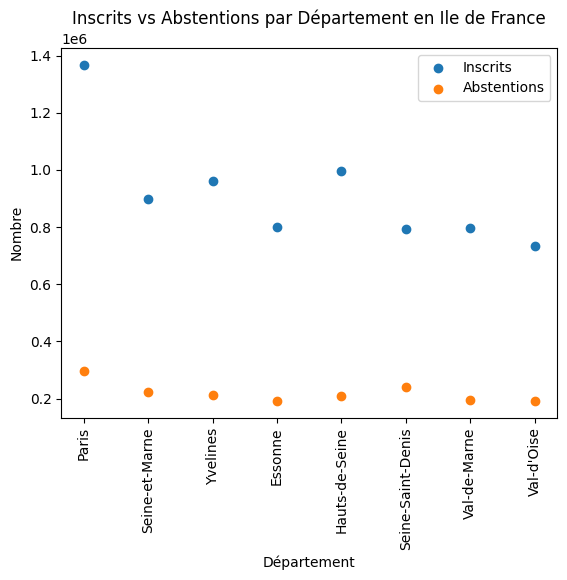

In [58]:

# Créer une figure et un axe
fig, ax = plt.subplots()

# Tracer les colonnes 'Inscrits' et 'Abstentions' en fonction de 'Libellé du département'
ax.scatter(donnees_ile_france['Libellé du département'], donnees_ile_france['Inscrits'], label='Inscrits')
ax.scatter(donnees_ile_france['Libellé du département'], donnees_ile_france['Abstentions'], label='Abstentions')

# Ajouter une légende
ax.legend()

# Personnaliser les étiquettes d'axe et le titre
ax.set_xlabel("Département")
ax.set_ylabel("Nombre")
ax.set_title("Inscrits vs Abstentions par Département en Ile de France")

# Faire pivoter les étiquettes des départements si nécessaire
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()



In [52]:
donnees_ile_france.head()

,Code du département,Libellé du département,Etat saisie,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
75,75,Paris,Complet,1368025,296668,21.69,1071357,78.31,11028,0.81,...,Philippe,5732,0.42,0.54,M,DUPONT-AIGNAN,Nicolas,9591,0.70,0.91
77,77,Seine-et-Marne,Complet,899303,223172,24.82,676131,75.18,11057,1.23,...,Philippe,4600,0.51,0.70,M,DUPONT-AIGNAN,Nicolas,15042,1.67,2.28
78,78,Yvelines,Complet,961245,211708,22.02,749537,77.98,9601,1.00,...,Philippe,3963,0.41,0.54,M,DUPONT-AIGNAN,Nicolas,13097,1.36,1.78
91,91,Essonne,Complet,799500,192200,24.04,607300,75.96,8954,1.12,...,Philippe,4306,0.54,0.72,M,DUPONT-AIGNAN,Nicolas,15203,1.90,2.56
92,92,Hauts-de-Seine,Complet,997667,208790,20.93,788877,79.07,11841,1.19,...,Philippe,3704,0.37,0.48,M,DUPONT-AIGNAN,Nicolas,9743,0.98,1.26


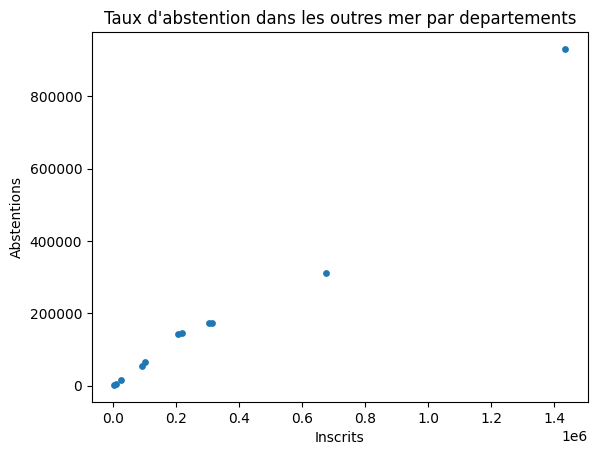

In [43]:
plt.scatter(donnees_outre_mer['Inscrits'], donnees_outre_mer['Abstentions'],s=15)
plt.xlabel('Inscrits')
plt.ylabel('Abstentions')
plt.title("Taux d'abstention dans les outres mer par departements")
plt.show()

In [64]:
population_ile_de_f = {
    "Taux Abs/Ins": donnees_ile_france['% Abs/Ins'].astype(float),
    "Nombre d'habitant": [2145906, 1428636, 1449723, 1306118, 1626213, 1655422, 1407972, 1251804]
}

df_pop_idf = pd.DataFrame(population_ile_de_f)

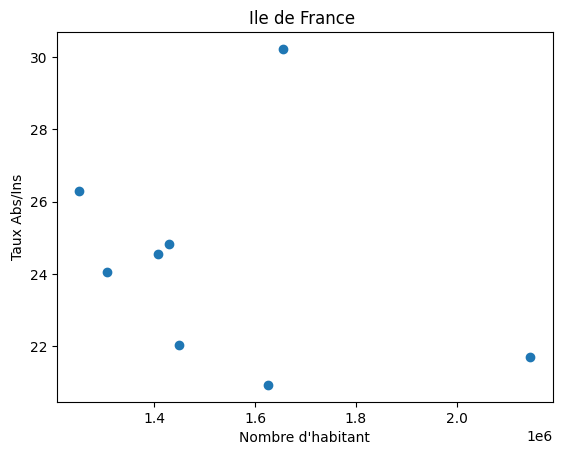

In [70]:
# Tracer le graphique de dispersion
plt.scatter(x=df_pop_idf["Nombre d'habitant"],y=df_pop_idf['Taux Abs/Ins'])

# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Nombre d'habitant")
plt.ylabel("Taux Abs/Ins")
plt.title("Ile de France ")

# Afficher le graphique
plt.show()


In [74]:
pop_fr=extraireDfFromExcel("/content/drive/MyDrive/dataset/population.xlsx")


In [85]:
pop_dep=pop_fr['Départements']
data_x=pop_dep['Population municipale']
# Retirer les lignes avec les valeurs "zb", "zv" ou "zn" dans la colonne "code depart"
dff = df_2022_dep.drop(df_2022_dep[df_2022_dep['Code du département'].isin(['ZM','ZN', 'ZP', 'ZS','ZX','ZW','ZZ'])].index)
data_y=dff['% Abs/Ins']
print("size y : "+str(data_y.size)+" x : "+str(data_x.size))

size y : 100 x : 100


In [84]:
print(pop_dep['Code département'])
print(dff['Code du département'])

0      01
1      02
2      03
3      04
4      05
     ... 
95     95
96    971
97    972
98    973
99    974
Name: Code département, Length: 100, dtype: object
0      01
1      02
2      03
3      04
4      05
       ..
96     ZA
97     ZB
98     ZC
99     ZD
100    ZM
Name: Code du département, Length: 101, dtype: object


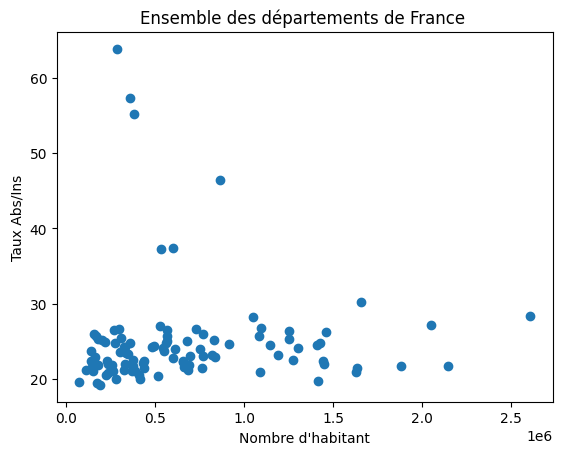

In [88]:
# Tracer le graphique de dispersion
plt.scatter(x=data_x,y=data_y)

# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Nombre d'habitant")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")

# Afficher le graphique
plt.show()

Text(0.5, 1.0, 'Ensemble des départements de France ')

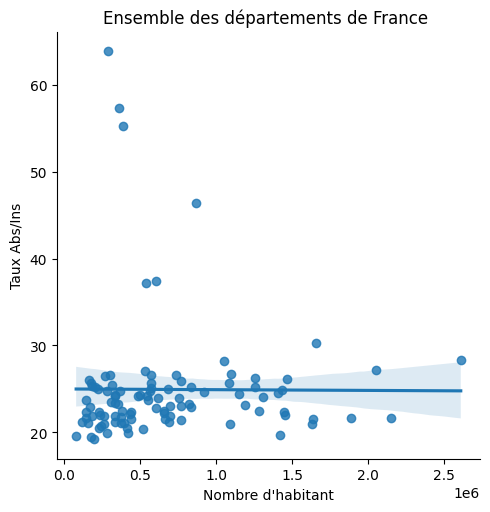

In [91]:
# Tracer le graphique de dispersion avec la droite de régression linéaire
abs_pop = {'x': data_x,'y': data_y}
data_fr = pd.DataFrame(abs_pop)
sns.lmplot(x="x", y='y', data=data_fr)
# Personnaliser les étiquettes d'axe et le titre
plt.xlabel("Nombre d'habitant")
plt.ylabel("Taux Abs/Ins")
plt.title("Ensemble des départements de France ")